## Bond matrix inversion test (diffusion_distance_tensor → bond_mat)

本 notebook 使用 `BondFlow.models.adapter.APMBackboneWrapper.bond_mat_2_dist_mat` 将 `bond_mat` 编码为 diffusion 距离特征，再用一个小型神经网络和 `DSMCrossEntropyLoss` 去解码回原始的 `bond_mat`，以测试在不同 diffusion 参数设置下，这个编码是否“可逆”。

思路：
- 给定随机生成的对称 `bond_mat`（非对角元素），通过 `bond_mat_2_dist_mat` 得到 pair embedding。
- 训练一个简单的 MLP 解码器，使其从 embedding 恢复 `bond_mat` 概率矩阵。
- 使用 `Loss.py` 中的 `DSMCrossEntropyLoss` 作为训练损失，并观察 loss 和 二值化准确率 的变化。


In [3]:
import math
import torch
import torch.nn as nn

from BondFlow.models.Loss import DSMCrossEntropyLoss
import BondFlow.data.SM_utlis as smu
from BondFlow.models.adapter import compute_rbf_and_project_chunked


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Diffusion 超参数（可以在这里改，完全与主模型解耦）----
#这里只是一个默认设置，你可以根据 base.yaml / apm.yaml 自己调整，对编码-解码实验本身没有硬性要求。
DIFF_TIMES = [1, 2, 8,9,16, 17,32,33,64,65]
DIFF_K = 600          # diffusion_map_features
DIFF_RBF_NUM = 32  # 与训练配置一致，用于 RBF 展开
DIFF_K_RATIO = 0.75
PAIR_EMBED_SIZE = 128


class BondEncoder(nn.Module):
    """近似复现 APMBackboneWrapper.bond_mat_2_dist_mat 功能的编码器（不加载任何主模型权重）。"""

    def __init__(self, times, k, rbf_num, k_ratio, pair_embed_size):
        super().__init__()
        self.times = times
        self.k = k
        self.rbf_num = rbf_num
        self.k_ratio = k_ratio
        self.pair_embed_size = pair_embed_size

        # diffusion_distance_tensor 输出形状: [B, 3L, 3L, T]
        # 之后在 compute_rbf_and_project_chunked 里进行 RBF 展开: T -> T * rbf_num
        # 因此 Linear 的输入特征维度为 len(times) * rbf_num
        in_dim = len(self.times) * self.rbf_num
        self.res_atom_proj = nn.Linear(in_dim, self.pair_embed_size)
        self.res_atom_score = nn.Sequential(
            nn.Linear(self.pair_embed_size, self.pair_embed_size),
            nn.ReLU(),
            nn.Linear(self.pair_embed_size, 1),
        )

    def forward(
        self,
        bond_mat: torch.Tensor,
        rf_idx: torch.Tensor,
        res_mask: torch.Tensor,
        bond_mask: torch.Tensor | None = None,
        head_mask: torch.Tensor | None = None,
        tail_mask: torch.Tensor | None = None,
        N_C_anchor: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """近似原版 atomic graph + 3x3 patch + ScoreNet + 稀疏聚合的完整实现。

        Args:
            bond_mat: [B, L, L]
            rf_idx: [B, L]
            res_mask: [B, L]
            bond_mask: [B, L, L] or None
            head_mask, tail_mask: [B, L] or None
            N_C_anchor: [B, L, L, 2] or None
        Returns:
            pair_feat: [B, L, L, pair_embed_size]
        """
        B, L_total = bond_mat.shape[:2]
        device = bond_mat.device

        # 默认: 若未提供 head/tail/N_C_anchor，则构造全 False / 全 0 的占位符
        if head_mask is None:
            head_mask = torch.zeros(B, L_total, dtype=torch.bool, device=device)
        if tail_mask is None:
            tail_mask = torch.zeros(B, L_total, dtype=torch.bool, device=device)
        if N_C_anchor is None:
            N_C_anchor = torch.zeros(B, L_total, L_total, 2, dtype=torch.bool, device=device)

        head_mask = head_mask.bool()
        tail_mask = tail_mask.bool()
        res_mask_bool = res_mask.bool()

        # --- 1. 计算 body 残基、局部索引等 ---
        body_mask_bool = res_mask_bool & (~head_mask) & (~tail_mask)
        body_counts = body_mask_bool.sum(dim=1)
        if int(body_counts.max().item()) == 0:
            raise ValueError("BondEncoder: no body residues; please provide valid res_mask")

        L_body_max = int(body_counts.max().item())
        N_atom = 3 * L_body_max

        # 初始化 owner_global = 自身索引，用于功能位归属 body
        owner_global = torch.arange(L_total, device=device).view(1, L_total).expand(B, L_total).clone()
        body_cumsum = body_mask_bool.long().cumsum(dim=1)
        body_local_all = body_cumsum - 1
        body_local_all = body_local_all.masked_fill(~body_mask_bool, -1)

        # N/C anchor 映射 (向量化版本)
        def _assign_owner_vectorized(layer_idx, func_mask):
            if not func_mask.any():
                return
            anchor_layer = N_C_anchor[..., layer_idx]  # [B, L, L]
            valid_anchor_cols = body_mask_bool.unsqueeze(1)
            masked_anchors = anchor_layer & valid_anchor_cols
            anchor_exists = masked_anchors.any(dim=2)
            anchor_idx = masked_anchors.float().argmax(dim=2)
            update_mask = func_mask & anchor_exists
            owner_global[update_mask] = anchor_idx[update_mask]

        _assign_owner_vectorized(0, head_mask)
        _assign_owner_vectorized(1, tail_mask)

        # 0->N, 1->CA, 2->C
        center_type = torch.full((B, L_total), 1, device=device, dtype=torch.long)
        center_type[head_mask] = 0
        center_type[tail_mask] = 2

        # --- 2. 构建 atomic adjacency（加权） ---
        A_atom = torch.zeros((B, N_atom, N_atom), device=device, dtype=bond_mat.dtype)

        # 2.1 Intra-residue N-CA, CA-C
        seq_range = torch.arange(L_body_max, device=device).unsqueeze(0)
        len_mask = seq_range < body_counts.unsqueeze(1)
        atom_valid_mask = len_mask.repeat_interleave(3, dim=1)  # [B, 3Lb]

        batch_idx_grid = torch.arange(B, device=device).unsqueeze(1).expand(B, L_body_max)
        b_ids = batch_idx_grid[len_mask]
        l_ids = seq_range.expand(B, L_body_max)[len_mask]

        n_ids = 3 * l_ids
        ca_ids = n_ids + 1
        c_ids = n_ids + 2

        b_intra = torch.cat([b_ids, b_ids, b_ids, b_ids])
        u_intra = torch.cat([n_ids, ca_ids, ca_ids, c_ids])
        v_intra = torch.cat([ca_ids, n_ids, c_ids, ca_ids])
        w_intra = torch.ones_like(b_intra, dtype=bond_mat.dtype)

        # 2.2 Peptide bonds C_i-N_{i+1}
        is_seq = (rf_idx[:, 1:] == rf_idx[:, :-1] + 1) & res_mask_bool[:, :-1] & res_mask_bool[:, 1:]
        seq_b, seq_i = torch.nonzero(is_seq, as_tuple=True)
        if seq_b.numel() > 0:
            owner_i = body_local_all[seq_b, seq_i]
            owner_ip1 = body_local_all[seq_b, seq_i + 1]
            valid_pep = (owner_i >= 0) & (owner_ip1 >= 0)
            seq_b = seq_b[valid_pep]
            owner_i = owner_i[valid_pep]
            owner_ip1 = owner_ip1[valid_pep]
            c_i = 3 * owner_i + 2
            n_ip1 = 3 * owner_ip1 + 0
            b_pep = torch.cat([seq_b, seq_b])
            u_pep = torch.cat([c_i, n_ip1])
            v_pep = torch.cat([n_ip1, c_i])
            w_pep = torch.ones_like(b_pep, dtype=bond_mat.dtype)
        else:
            b_pep = u_pep = v_pep = w_pep = torch.empty(0, device=device, dtype=bond_mat.dtype)

        # 2.3 Special bonds from bond_mat（保留权重）
        threshold = 1e-4
        bm_mask = (bond_mat > threshold)
        eye_total = torch.eye(L_total, device=device, dtype=torch.bool).unsqueeze(0)
        bm_mask = bm_mask & (~eye_total)
        sp_b, sp_i, sp_j = torch.nonzero(bm_mask, as_tuple=True)
        if sp_b.numel() > 0:
            edge_weights = bond_mat[sp_b, sp_i, sp_j]
            owner_i_g = owner_global[sp_b, sp_i]
            owner_j_g = owner_global[sp_b, sp_j]
            owner_i_l = body_local_all[sp_b, owner_i_g]
            owner_j_l = body_local_all[sp_b, owner_j_g]
            valid_sp = (owner_i_l >= 0) & (owner_j_l >= 0)
            sp_b = sp_b[valid_sp]
            edge_weights = edge_weights[valid_sp]
            owner_i_l = owner_i_l[valid_sp]
            owner_j_l = owner_j_l[valid_sp]
            t_i = center_type[sp_b, sp_i[valid_sp]]
            t_j = center_type[sp_b, sp_j[valid_sp]]
            atom_i = 3 * owner_i_l + t_i
            atom_j = 3 * owner_j_l + t_j
            b_sp = torch.cat([sp_b, sp_b])
            u_sp = torch.cat([atom_i, atom_j])
            v_sp = torch.cat([atom_j, atom_i])
            w_sp = torch.cat([edge_weights, edge_weights])
        else:
            b_sp = u_sp = v_sp = w_sp = torch.empty(0, device=device, dtype=bond_mat.dtype)

        # 合并所有边
        b_all = torch.cat([b_intra, b_pep, b_sp])
        u_all = torch.cat([u_intra, u_pep, u_sp])
        v_all = torch.cat([v_intra, v_pep, v_sp])
        w_all = torch.cat([w_intra, w_pep, w_sp])
        A_atom.index_put_((b_all, u_all, v_all), w_all, accumulate=False)

        # --- 3. Diffusion distance on atomic graph（rbf_num=0，节省内存） ---
        res_dist_atom = smu.diffusion_distance_tensor(
            A_adj_batch=A_atom,
            times=self.times,
            k=self.k,
            skip_top=True,
            node_mask=atom_valid_mask.int(),
            rbf_num=0,
            rbf_gamma=None,
            k_ratio=self.k_ratio,
        )  # [B_loc, 3L, 3L, T]
        B_loc, N_loc, _, T = res_dist_atom.shape

        # patch mask [B, L, L, 9]
        atom_mask_2d = atom_valid_mask.unsqueeze(2) & atom_valid_mask.unsqueeze(1)
        mask_patches = atom_mask_2d.view(B_loc, L_body_max, 3, L_body_max, 3).permute(0, 1, 3, 2, 4).reshape(
            B_loc, L_body_max, L_body_max, 9
        )

        # [B, L, L, 9, T]
        X = res_dist_atom.view(B_loc, L_body_max, 3, L_body_max, 3, T).permute(0, 1, 3, 2, 4, 5)
        X = X.reshape(B_loc, L_body_max, L_body_max, 9, T)

        # RBF + Linear 投影（与原代码一致，使用 chunk 版）
        X_proj = compute_rbf_and_project_chunked(
            projection_layer=self.res_atom_proj,
            dist_patches=X,
            mask_patches=mask_patches,
            rbf_num=self.rbf_num,
            rbf_gamma=None,
            chunk_size=16,
        )  # [B, L_body_max, L_body_max, 9, pair_embed_size]

        # --- 4. 稀疏聚合，把 3x3 patch 映射回 [B, L_total, L_total, pair_embed_size] ---
        # 构建 local body index map
        local_map = torch.gather(body_local_all, 1, owner_global)
        valid_map = local_map >= 0
        I_map = local_map.unsqueeze(2).expand(B, L_total, L_total)
        J_map = local_map.unsqueeze(1).expand(B, L_total, L_total)
        valid_pair = valid_map.unsqueeze(2) & valid_map.unsqueeze(1)
        I_gather = I_map.masked_fill(~valid_pair, 0)
        J_gather = J_map.masked_fill(~valid_pair, 0)

        d_hidden = X_proj.shape[-1]
        feat_full = torch.zeros((B, L_total, L_total, d_hidden), dtype=X_proj.dtype, device=device)

        def _aggregate_and_fill(token_indices: torch.Tensor, active_mask: torch.Tensor, transpose: bool = False):
            if not active_mask.any():
                return
            b, i, j = torch.nonzero(active_mask, as_tuple=True)
            if transpose:
                i_b = I_gather[b, j, i]
                j_b = J_gather[b, j, i]
            else:
                i_b = I_gather[b, i, j]
                j_b = J_gather[b, i, j]
            valid = (i_b >= 0) & (j_b >= 0)
            if not valid.any():
                return
            b = b[valid]
            i = i[valid]
            j = j[valid]
            i_b = i_b[valid]
            j_b = j_b[valid]
            sub_x = X_proj[b, i_b, j_b]  # [N_active, 9, D]
            sub_x = sub_x[:, token_indices]
            scores = self.res_atom_score(sub_x)  # [N_active, K, 1]
            attn = torch.softmax(scores, dim=1)
            res = (attn * sub_x).sum(dim=1)      # [N_active, D]
            feat_full[b, i, j] = res

        head_r = head_mask.view(B, L_total, 1)
        tail_r = tail_mask.view(B, L_total, 1)
        head_c = head_mask.view(B, 1, L_total)
        tail_c = tail_mask.view(B, 1, L_total)
        valid_p = valid_pair

        # 4.1 body-body: 所有 9 个 token
        idx_all = torch.arange(9, device=device)
        _aggregate_and_fill(idx_all, valid_p, transpose=False)

        # 4.2 端点行/列: N 使用 tokens 0,1,2；C 使用 6,7,8
        idx_N = torch.tensor([0, 1, 2], device=device)
        _aggregate_and_fill(idx_N, (head_r & valid_p), transpose=False)
        _aggregate_and_fill(idx_N, (head_c & valid_p), transpose=True)

        idx_C = torch.tensor([6, 7, 8], device=device)
        _aggregate_and_fill(idx_C, (tail_r & valid_p), transpose=False)
        _aggregate_and_fill(idx_C, (tail_c & valid_p), transpose=True)

        # 4.3 特殊端点对: N-N (token 0), C-C (token 8), C-N (token 6)
        idx_NN = torch.tensor([0], device=device)
        _aggregate_and_fill(idx_NN, (head_r & head_c & valid_p), transpose=False)

        idx_CC = torch.tensor([8], device=device)
        _aggregate_and_fill(idx_CC, (tail_r & tail_c & valid_p), transpose=False)

        idx_CN = torch.tensor([6], device=device)
        _aggregate_and_fill(idx_CN, (tail_r & head_c & valid_p), transpose=False)
        _aggregate_and_fill(idx_CN, (head_r & tail_c & valid_p), transpose=True)

        # feat_full 即为原版 bond_mat_2_dist_mat 返回的 res_dist_feat（未拼 time_embedding）
        return feat_full


encoder = BondEncoder(
    times=DIFF_TIMES,
    k=DIFF_K,
    rbf_num=DIFF_RBF_NUM,
    k_ratio=DIFF_K_RATIO,
    pair_embed_size=PAIR_EMBED_SIZE,
).to(device)

# DSMCrossEntropyLoss 实例
bond_loss_fn = DSMCrossEntropyLoss(gamma=2.0, off_diagonal_weight=1.0)



Using device: cuda


In [4]:
# 随机生成对称 bond_mat 以及对应的 mask
def generate_random_bond_batch(batch_size: int, L: int, device: torch.device, num_swaps: int = None):
     """生成一批随机对称置换矩阵（0-1二值）。
 
     Args:
         batch_size: 批大小 B
         L: 残基数
         device: 设备
         num_swaps: 随机交换的次数（默认约为 L/4）。每次交换会在非对角线添加一对对称的1，同时将对应对角线位置设为0。
     """
     # 初始化为单位矩阵（对角矩阵）
     bond_mat = torch.eye(L, device=device, dtype=torch.float).unsqueeze(0).expand(batch_size, -1, -1)
     
     if num_swaps is None:
         num_swaps = max(1, L //40)
     
     # 对每个batch独立生成
     for b in range(batch_size):
         # 随机选择 num_swaps 个位置对进行交换
         # 每次交换：在(i,j)和(j,i)设为1，在(i,i)和(j,j)设为0
         indices = torch.randperm(L, device=device)
         for swap_idx in range(0, min(num_swaps * 2, L - 1), 2):
             if swap_idx + 1 >= L:
                 break
             i = indices[swap_idx].item()
             j = indices[swap_idx + 1].item()
             
             # 执行交换：在(i,j)和(j,i)设为1，在(i,i)和(j,j)设为0
             bond_mat[b, i, j] = 1.0
             bond_mat[b, j, i] = 1.0
             bond_mat[b, i, i] = 0.0
             bond_mat[b, j, j] = 0.0
 
     # 残基 mask：这里只用全 1
     res_mask = torch.ones(batch_size, L, device=device)
 
     # 2D mask：只在非对角元素上计算损失
     eye = torch.eye(L, device=device, dtype=torch.bool).unsqueeze(0)
     mask_2d = (~eye).expand(batch_size, -1, -1)
 
     return bond_mat, res_mask, mask_2d


class BondDecoder(nn.Module):
    """简单的 MLP，把 pair embedding 解码回 bond_mat。"""

    def __init__(self, in_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, pair_feat: torch.Tensor) -> torch.Tensor:
        """pair_feat: [B, L, L, D] -> out: [B, L, L] in [0,1]."""
        B, L1, L2, D = pair_feat.shape
        x = pair_feat.reshape(B * L1 * L2, D)
        out = self.mlp(x).reshape(B, L1, L2)
        # 对称化，保证输出矩阵接近对称
        out = 0.5 * (out + out.transpose(1, 2))
        return out.clamp(0.0, 1.0)


# 一些基本超参数
BATCH_SIZE = 4
L = 250
NUM_STEPS = 1000
LR = 1e-3

# 解码器与优化器
decoder = BondDecoder(in_dim=PAIR_EMBED_SIZE, hidden_dim=256).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=LR)

# 记录训练过程中的loss和accuracy
loss_history = []
acc_history = []
step_history = []

for step in range(1, NUM_STEPS + 1):
    bond_mat, res_mask, mask_2d = generate_random_bond_batch(BATCH_SIZE, L, device)

    # 简单的 rf_idx（单链递增），以及 dummy 的 head/tail/N_C_anchor
    B_cur, L_cur, _ = bond_mat.shape
    rf_idx = torch.arange(L_cur, device=device).unsqueeze(0).expand(B_cur, -1)
    head_mask = torch.zeros(B_cur, L_cur, dtype=torch.bool, device=device)
    tail_mask = torch.zeros(B_cur, L_cur, dtype=torch.bool, device=device)
    N_C_anchor = torch.zeros(B_cur, L_cur, L_cur, 2, dtype=torch.bool, device=device)

    with torch.no_grad():
        # [B, L, L, D_pair]
        pair_feat = encoder(
            bond_mat=bond_mat,
            rf_idx=rf_idx,
            res_mask=res_mask,
            bond_mask=None,
            head_mask=head_mask,
            tail_mask=tail_mask,
            N_C_anchor=N_C_anchor,
        )

    pred_bond = decoder(pair_feat)

    loss = bond_loss_fn(pred_bond, bond_mat, mask_2d)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 记录loss和accuracy
    with torch.no_grad():
        # 简单的二值化准确率（0.5 阈值）
        pred_bin = (pred_bond > 0.5).float()
        target_bin = (bond_mat > 0.5).float()
        correct = ((pred_bin == target_bin) * mask_2d).sum()
        total = mask_2d.sum()
        acc = (correct / total).item()
    
    loss_history.append(loss.item())
    acc_history.append(acc)
    step_history.append(step)

    if step % 20 == 0 or step == 1:
        print(f"step {step:4d} | loss = {loss.item():.4f} | bin-acc = {acc:.3f}")




compute_rbf_and_project_chunked: processed 250 rows in 0.0010 seconds (chunk_size=16)
real offdiagonal gggggg :  tensor(0.5140, device='cuda:0', grad_fn=<DivBackward0>) denom:  tensor(192., device='cuda:0')
Debug - Real Off-Diag Pred: 0.5139867663383484 | Real Mean (Pred>0.75): N/A (No High Conf)
step    1 | loss = 1026.5717 | bin-acc = 0.001
compute_rbf_and_project_chunked: processed 250 rows in 0.0009 seconds (chunk_size=16)
real offdiagonal gggggg :  tensor(0.5070, device='cuda:0', grad_fn=<DivBackward0>) denom:  tensor(192., device='cuda:0')
Debug - Real Off-Diag Pred: 0.5069663524627686 | Real Mean (Pred>0.75): N/A (No High Conf)
compute_rbf_and_project_chunked: processed 250 rows in 0.0009 seconds (chunk_size=16)
real offdiagonal gggggg :  tensor(0.4993, device='cuda:0', grad_fn=<DivBackward0>) denom:  tensor(192., device='cuda:0')
Debug - Real Off-Diag Pred: 0.4993356168270111 | Real Mean (Pred>0.75): N/A (No High Conf)
compute_rbf_and_project_chunked: processed 250 rows in 0.00

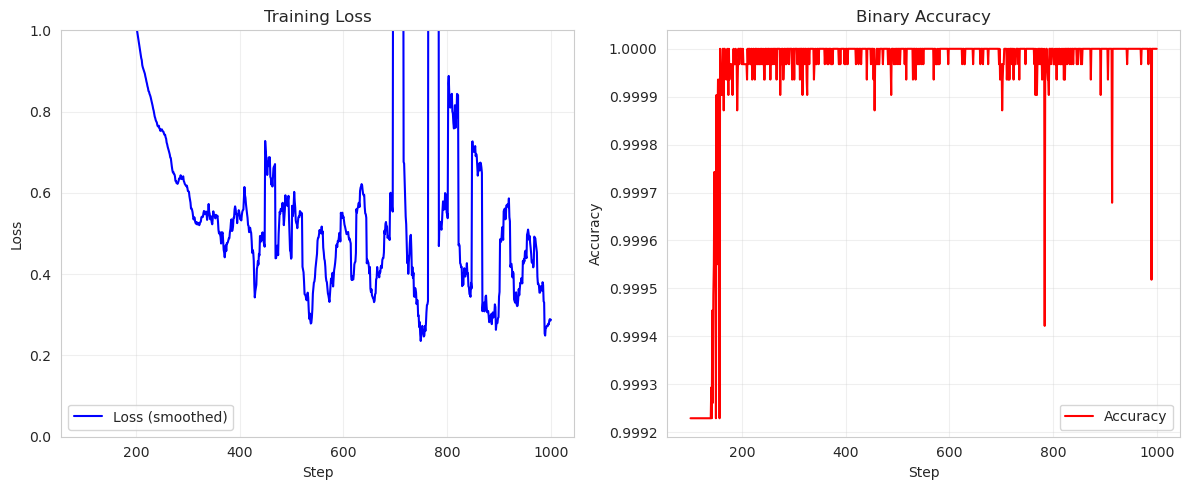


Final loss: 0.5335
Final accuracy: 1.000


In [5]:

# 绘制loss和accuracy曲线
import matplotlib.pyplot as plt
import numpy as np

# 移动平均函数
def moving_average(data, window_size=50):
    """计算移动平均"""
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 5))

# 绘制loss曲线
plt.subplot(1, 2, 1)
# 计算平滑后的loss
window_size = 20
if len(loss_history) >= window_size:
    smoothed_loss = moving_average(loss_history, window_size)
    smoothed_steps = step_history[window_size-1:]  # 移动平均后，步数从window_size-1开始
    # 从第250步开始显示（如果数据足够的话）
    display_start = 100
    if display_start >= window_size - 1:
        start_idx = display_start - (window_size - 1)
        plt.plot(smoothed_steps[start_idx:], smoothed_loss[start_idx:], 'b-', linewidth=1.5, label='Loss (smoothed)')
    else:
        plt.plot(smoothed_steps, smoothed_loss, 'b-', linewidth=1.5, label='Loss (smoothed)')
else:
    plt.plot(step_history[100:], loss_history[100:], 'b-', linewidth=1.5, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()

# 绘制accuracy曲线
plt.subplot(1, 2, 2)
plt.plot(step_history[100:], acc_history[100:], 'r-', linewidth=1.5, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Binary Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nFinal loss: {loss_history[-1]:.4f}")
print(f"Final accuracy: {acc_history[-1]:.3f}")

### 如何测试不同 diffusion 参数

- 如需改变 `diffusion_map_times` 或 `diffusion_rbf_num`，建议：
  - 先在第二个代码单元中修改 `preprocess_conf` 对应字段；
  - **若改变了 `diffusion_map_times` 的长度或 `diffusion_rbf_num`，请重新构建一次 `APMBackboneWrapper`（重新运行 `build_design_model("apm_backbone", ...)` 那一格），以保证 `res_atom_proj` 的输入维度匹配。**
- 示例（保持 times 长度不变，只改数值）：

```python
preprocess_conf.diffusion_map_times = [1, 4, 8, 12, 16, 20, 24, 28]  # 长度仍为 8
preprocess_conf.diffusion_k_ratio = 0.3
```

- 每次修改完配置后，重新运行训练单元，比较 `loss` 和 `bin-acc` 的收敛情况，即可直观对比在不同参数下，`bond_mat_2_dist_mat` 产生的表示是否更容易被神经网络解码回原始 `bond_mat`。
